In [1]:
!python -V

Python 3.9.12


In [2]:
!mlflow ui

[2025-09-23 18:45:32 +0000] [20535] [INFO] Starting gunicorn 23.0.0
[2025-09-23 18:45:32 +0000] [20535] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-09-23 18:45:32 +0000] [20535] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-09-23 18:45:33 +0000] [20535] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-09-23 18:45:33 +0000] [20535] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-09-23 18:45:34 +0000] [20535] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-09-23 18:45:34 +0000] [20535] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
^C


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

2025/09/23 18:45:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/09/23 18:45:41 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/09/23 18:45:41 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops_datatalksclub/02-experiment-tracking/mlruns/1', creation_time=1758653141838, experiment_id='1', last_update_time=1758653141838, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
df = pd.read_parquet('/workspaces/mlops_datatalksclub/data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)**(0.5)

9.775464552087287

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


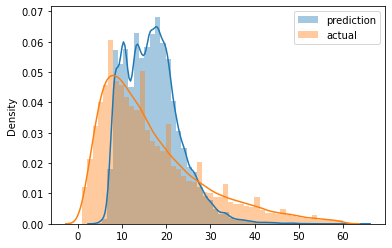

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('/workspaces/mlops_datatalksclub/data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/workspaces/mlops_datatalksclub/data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)**(0.5)

7.479562160810692

In [18]:
with open('/workspaces/mlops_datatalksclub/models/model.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():
    mlflow.set_tag('test for hyperparameter','learning rate alpha')
    alpha=0.01
    lr = Lasso(alpha)
    mlflow.log_param('learning-rate',alpha)
    mlflow.log_param('model-name','Lasso Regression')
    mlflow.log_param('training-data','/workspaces/mlops_datatalksclub/data/green_tripdata_2021-01.parquet')
    mlflow.log_param('validation-data','/workspaces/mlops_datatalksclub/data/green_tripdata_2021-02.parquet')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse=mean_squared_error(y_val, y_pred)**(0.5)
    mlflow.log_metric('rmse',rmse)

In [29]:
import xgboost as xgb
from hyperopt import fmin,tpe,hp,STATUS_OK,Trials
from hyperopt.pyll import scope

In [32]:
train=xgb.DMatrix(X_train,label=y_train)
valid=xgb.DMatrix(X_val,label=y_val)

In [37]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model','xgboost')
        mlflow.log_params(params)
        booster=xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,'validation')],
            early_stopping_rounds=2
        )
        y_pred=booster.predict(valid)
        rsme=mean_squared_error(y_val, y_pred)**(0.5)
        mlflow.log_metric('rmse',rmse)
        return {'loss':rsme,'status':STATUS_OK}
        

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                       | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:25:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45242                                                       
[1]	validation-rmse:10.78677                                                       
[2]	validation-rmse:10.20651                                                       
[3]	validation-rmse:9.70250                                                        
[4]	validation-rmse:9.26556                                                        
[5]	validation-rmse:8.88914                                                        
[6]	validation-rmse:8.56555                                                        
[7]	validation-rmse:8.28801                                                        
[8]	validation-rmse:8.05106                                                        
[9]	validation-rmse:7.84867                                                        
[10]	validation-rmse:7.67640                                                       
[11]	validation-rmse:7.53015                                                

[97]	validation-rmse:6.58953                                                       
[98]	validation-rmse:6.58926                                                       
[99]	validation-rmse:6.58873                                                       
[100]	validation-rmse:6.58851                                                      
[101]	validation-rmse:6.58831                                                      
[102]	validation-rmse:6.58809                                                      
[103]	validation-rmse:6.58783                                                      
[104]	validation-rmse:6.58762                                                      
[105]	validation-rmse:6.58723                                                      
[106]	validation-rmse:6.58702                                                      
[107]	validation-rmse:6.58686                                                      
[108]	validation-rmse:6.58666                                               

[194]	validation-rmse:6.57365                                                      
[195]	validation-rmse:6.57357                                                      
[196]	validation-rmse:6.57339                                                      
[197]	validation-rmse:6.57335                                                      
[198]	validation-rmse:6.57331                                                      
[199]	validation-rmse:6.57321                                                      
[200]	validation-rmse:6.57318                                                      
[201]	validation-rmse:6.57314                                                      
[202]	validation-rmse:6.57292                                                      
[203]	validation-rmse:6.57282                                                      
[204]	validation-rmse:6.57279                                                      
[205]	validation-rmse:6.57275                                               

[291]	validation-rmse:6.56672                                                      
[292]	validation-rmse:6.56676                                                      
[293]	validation-rmse:6.56673                                                      
[294]	validation-rmse:6.56672                                                      
[295]	validation-rmse:6.56674                                                      
[296]	validation-rmse:6.56667                                                      
[297]	validation-rmse:6.56657                                                      
[298]	validation-rmse:6.56650                                                      
[299]	validation-rmse:6.56646                                                      
[300]	validation-rmse:6.56644                                                      
[301]	validation-rmse:6.56636                                                      
[302]	validation-rmse:6.56633                                               

[388]	validation-rmse:6.56142                                                      
[389]	validation-rmse:6.56141                                                      
[390]	validation-rmse:6.56146                                                      
[391]	validation-rmse:6.56141                                                      
[392]	validation-rmse:6.56132                                                      
[393]	validation-rmse:6.56126                                                      
[394]	validation-rmse:6.56130                                                      
[395]	validation-rmse:6.56122                                                      
[396]	validation-rmse:6.56117                                                      
[397]	validation-rmse:6.56105                                                      
[398]	validation-rmse:6.56097                                                      
[399]	validation-rmse:6.56094                                               

[485]	validation-rmse:6.55804                                                      
[486]	validation-rmse:6.55812                                                      
[487]	validation-rmse:6.55811                                                      
[488]	validation-rmse:6.55810                                                      
[489]	validation-rmse:6.55796                                                      
[490]	validation-rmse:6.55774                                                      
[491]	validation-rmse:6.55776                                                      
[492]	validation-rmse:6.55776                                                      
[493]	validation-rmse:6.55780                                                      
[494]	validation-rmse:6.55774                                                      
[495]	validation-rmse:6.55776                                                      
[496]	validation-rmse:6.55769                                               

[582]	validation-rmse:6.55583                                                      
[583]	validation-rmse:6.55582                                                      
[584]	validation-rmse:6.55569                                                      
[585]	validation-rmse:6.55566                                                      
[586]	validation-rmse:6.55568                                                      
[587]	validation-rmse:6.55567                                                      
[588]	validation-rmse:6.55566                                                      
[589]	validation-rmse:6.55561                                                      
[590]	validation-rmse:6.55562                                                      
[591]	validation-rmse:6.55561                                                      
[592]	validation-rmse:6.55556                                                      
[593]	validation-rmse:6.55551                                               

[679]	validation-rmse:6.55380                                                      
[680]	validation-rmse:6.55376                                                      
[681]	validation-rmse:6.55375                                                      
[682]	validation-rmse:6.55370                                                      
[683]	validation-rmse:6.55372                                                      
[684]	validation-rmse:6.55381                                                      
[685]	validation-rmse:6.55379                                                      
[686]	validation-rmse:6.55375                                                      
[687]	validation-rmse:6.55376                                                      
[688]	validation-rmse:6.55374                                                      
[689]	validation-rmse:6.55373                                                      
[690]	validation-rmse:6.55377                                               

[776]	validation-rmse:6.55278                                                      
[777]	validation-rmse:6.55283                                                      
[778]	validation-rmse:6.55279                                                      
[779]	validation-rmse:6.55273                                                      
[780]	validation-rmse:6.55277                                                      
[781]	validation-rmse:6.55281                                                      
[782]	validation-rmse:6.55275                                                      
[783]	validation-rmse:6.55276                                                      
[784]	validation-rmse:6.55273                                                      
[785]	validation-rmse:6.55283                                                      
[786]	validation-rmse:6.55286                                                      
[787]	validation-rmse:6.55280                                               

[873]	validation-rmse:6.55185                                                      
[874]	validation-rmse:6.55184                                                      
[875]	validation-rmse:6.55180                                                      
[876]	validation-rmse:6.55180                                                      
[877]	validation-rmse:6.55180                                                      
[878]	validation-rmse:6.55184                                                      
[879]	validation-rmse:6.55189                                                      
[880]	validation-rmse:6.55186                                                      
[881]	validation-rmse:6.55184                                                      
[882]	validation-rmse:6.55186                                                      
[883]	validation-rmse:6.55183                                                      
[884]	validation-rmse:6.55185                                               

[970]	validation-rmse:6.55110                                                      
[971]	validation-rmse:6.55112                                                      
[972]	validation-rmse:6.55111                                                      
[973]	validation-rmse:6.55112                                                      
[974]	validation-rmse:6.55110                                                      
[975]	validation-rmse:6.55111                                                      
[976]	validation-rmse:6.55111                                                      
[977]	validation-rmse:6.55114                                                      
[978]	validation-rmse:6.55119                                                      
[979]	validation-rmse:6.55118                                                      
[980]	validation-rmse:6.55118                                                      
[981]	validation-rmse:6.55116                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:29:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77422                                                       
[1]	validation-rmse:11.36719                                                       
[2]	validation-rmse:10.98936                                                       
[3]	validation-rmse:10.63969                                                       
[4]	validation-rmse:10.31561                                                       
[5]	validation-rmse:10.01645                                                       
[6]	validation-rmse:9.74001                                                        
[7]	validation-rmse:9.48401                                                        
[8]	validation-rmse:9.24934                                                        
[9]	validation-rmse:9.03336                                                        
[10]	validation-rmse:8.83424                                                       
[11]	validation-rmse:8.65253                                                

[97]	validation-rmse:6.64636                                                       
[98]	validation-rmse:6.64570                                                       
[99]	validation-rmse:6.64521                                                       
[100]	validation-rmse:6.64456                                                      
[101]	validation-rmse:6.64424                                                      
[102]	validation-rmse:6.64405                                                      
[103]	validation-rmse:6.64358                                                      
[104]	validation-rmse:6.64319                                                      
[105]	validation-rmse:6.64216                                                      
[106]	validation-rmse:6.64160                                                      
[107]	validation-rmse:6.64121                                                      
[108]	validation-rmse:6.64083                                               

[194]	validation-rmse:6.61001                                                      
[195]	validation-rmse:6.60973                                                      
[196]	validation-rmse:6.60926                                                      
[197]	validation-rmse:6.60907                                                      
[198]	validation-rmse:6.60892                                                      
[199]	validation-rmse:6.60879                                                      
[200]	validation-rmse:6.60836                                                      
[201]	validation-rmse:6.60821                                                      
[202]	validation-rmse:6.60810                                                      
[203]	validation-rmse:6.60782                                                      
[204]	validation-rmse:6.60767                                                      
[205]	validation-rmse:6.60755                                               

[291]	validation-rmse:6.58785                                                      
[292]	validation-rmse:6.58761                                                      
[293]	validation-rmse:6.58737                                                      
[294]	validation-rmse:6.58727                                                      
[295]	validation-rmse:6.58703                                                      
[296]	validation-rmse:6.58699                                                      
[297]	validation-rmse:6.58670                                                      
[298]	validation-rmse:6.58650                                                      
[299]	validation-rmse:6.58630                                                      
[300]	validation-rmse:6.58615                                                      
[301]	validation-rmse:6.58600                                                      
[302]	validation-rmse:6.58556                                               

[388]	validation-rmse:6.56966                                                      
[389]	validation-rmse:6.56953                                                      
[390]	validation-rmse:6.56942                                                      
[391]	validation-rmse:6.56919                                                      
[392]	validation-rmse:6.56901                                                      
[393]	validation-rmse:6.56868                                                      
[394]	validation-rmse:6.56849                                                      
[395]	validation-rmse:6.56841                                                      
[396]	validation-rmse:6.56818                                                      
[397]	validation-rmse:6.56786                                                      
[398]	validation-rmse:6.56768                                                      
[399]	validation-rmse:6.56774                                               

[485]	validation-rmse:6.55426                                                      
[486]	validation-rmse:6.55414                                                      
[487]	validation-rmse:6.55388                                                      
[488]	validation-rmse:6.55376                                                      
[489]	validation-rmse:6.55340                                                      
[490]	validation-rmse:6.55319                                                      
[491]	validation-rmse:6.55318                                                      
[492]	validation-rmse:6.55297                                                      
[493]	validation-rmse:6.55274                                                      
[494]	validation-rmse:6.55260                                                      
[495]	validation-rmse:6.55229                                                      
[496]	validation-rmse:6.55208                                               

[582]	validation-rmse:6.54061                                                      
[583]	validation-rmse:6.54044                                                      
[584]	validation-rmse:6.54018                                                      
[585]	validation-rmse:6.54000                                                      
[586]	validation-rmse:6.53998                                                      
[587]	validation-rmse:6.53986                                                      
[588]	validation-rmse:6.53988                                                      
[589]	validation-rmse:6.53973                                                      
[590]	validation-rmse:6.53957                                                      
[591]	validation-rmse:6.53939                                                      
[592]	validation-rmse:6.53945                                                      
[593]	validation-rmse:6.53920                                               

[679]	validation-rmse:6.52854                                                      
[680]	validation-rmse:6.52840                                                      
[681]	validation-rmse:6.52828                                                      
[682]	validation-rmse:6.52812                                                      
[683]	validation-rmse:6.52790                                                      
[684]	validation-rmse:6.52774                                                      
[685]	validation-rmse:6.52765                                                      
[686]	validation-rmse:6.52756                                                      
[687]	validation-rmse:6.52748                                                      
[688]	validation-rmse:6.52743                                                      
[689]	validation-rmse:6.52728                                                      
[690]	validation-rmse:6.52729                                               

[776]	validation-rmse:6.51663                                                      
[777]	validation-rmse:6.51650                                                      
[778]	validation-rmse:6.51645                                                      
[779]	validation-rmse:6.51622                                                      
[780]	validation-rmse:6.51627                                                      
[781]	validation-rmse:6.51608                                                      
[782]	validation-rmse:6.51590                                                      
[783]	validation-rmse:6.51580                                                      
[784]	validation-rmse:6.51543                                                      
[785]	validation-rmse:6.51533                                                      
[786]	validation-rmse:6.51525                                                      
[787]	validation-rmse:6.51520                                               

[873]	validation-rmse:6.50716                                                      
[874]	validation-rmse:6.50711                                                      
[875]	validation-rmse:6.50698                                                      
[876]	validation-rmse:6.50687                                                      
[877]	validation-rmse:6.50676                                                      
[878]	validation-rmse:6.50663                                                      
[879]	validation-rmse:6.50647                                                      
[880]	validation-rmse:6.50637                                                      
[881]	validation-rmse:6.50631                                                      
[882]	validation-rmse:6.50610                                                      
[883]	validation-rmse:6.50599                                                      
[884]	validation-rmse:6.50589                                               

[970]	validation-rmse:6.49877                                                      
[971]	validation-rmse:6.49878                                                      
[972]	validation-rmse:6.49871                                                      
[973]	validation-rmse:6.49866                                                      
[974]	validation-rmse:6.49862                                                      
[975]	validation-rmse:6.49850                                                      
[976]	validation-rmse:6.49846                                                      
[977]	validation-rmse:6.49842                                                      
[978]	validation-rmse:6.49828                                                      
[979]	validation-rmse:6.49805                                                      
[980]	validation-rmse:6.49803                                                      
[981]	validation-rmse:6.49797                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:31:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.56127                                                       
[1]	validation-rmse:10.97706                                                       
[2]	validation-rmse:10.45411                                                       
[3]	validation-rmse:9.98753                                                        
[4]	validation-rmse:9.57204                                                        
[5]	validation-rmse:9.20414                                                        
[6]	validation-rmse:8.87622                                                        
[7]	validation-rmse:8.58712                                                        
[8]	validation-rmse:8.33175                                                        
[9]	validation-rmse:8.10712                                                        
[10]	validation-rmse:7.90899                                                       
[11]	validation-rmse:7.73760                                                

[97]	validation-rmse:6.41311                                                       
[98]	validation-rmse:6.41242                                                       
[99]	validation-rmse:6.41164                                                       
[100]	validation-rmse:6.41107                                                      
[101]	validation-rmse:6.41041                                                      
[102]	validation-rmse:6.40995                                                      
[103]	validation-rmse:6.40911                                                      
[104]	validation-rmse:6.40818                                                      
[105]	validation-rmse:6.40783                                                      
[106]	validation-rmse:6.40735                                                      
[107]	validation-rmse:6.40656                                                      
[108]	validation-rmse:6.40623                                               

[194]	validation-rmse:6.37127                                                      
[195]	validation-rmse:6.37116                                                      
[196]	validation-rmse:6.37086                                                      
[197]	validation-rmse:6.37047                                                      
[198]	validation-rmse:6.37027                                                      
[199]	validation-rmse:6.36994                                                      
[200]	validation-rmse:6.36965                                                      
[201]	validation-rmse:6.36918                                                      
[202]	validation-rmse:6.36877                                                      
[203]	validation-rmse:6.36833                                                      
[204]	validation-rmse:6.36797                                                      
[205]	validation-rmse:6.36779                                               

[291]	validation-rmse:6.34854                                                      
[292]	validation-rmse:6.34837                                                      
[293]	validation-rmse:6.34801                                                      
[294]	validation-rmse:6.34780                                                      
[295]	validation-rmse:6.34773                                                      
[296]	validation-rmse:6.34768                                                      
[297]	validation-rmse:6.34746                                                      
[298]	validation-rmse:6.34728                                                      
[299]	validation-rmse:6.34713                                                      
[300]	validation-rmse:6.34700                                                      
[301]	validation-rmse:6.34675                                                      
[302]	validation-rmse:6.34653                                               

[388]	validation-rmse:6.33299                                                      
[389]	validation-rmse:6.33286                                                      
[390]	validation-rmse:6.33273                                                      
[391]	validation-rmse:6.33260                                                      
[392]	validation-rmse:6.33245                                                      
[393]	validation-rmse:6.33235                                                      
[394]	validation-rmse:6.33226                                                      
[395]	validation-rmse:6.33222                                                      
[396]	validation-rmse:6.33216                                                      
[397]	validation-rmse:6.33213                                                      
[398]	validation-rmse:6.33201                                                      
[399]	validation-rmse:6.33148                                               

[485]	validation-rmse:6.32183                                                      
[486]	validation-rmse:6.32177                                                      
[487]	validation-rmse:6.32180                                                      
[488]	validation-rmse:6.32178                                                      
[489]	validation-rmse:6.32170                                                      
[490]	validation-rmse:6.32163                                                      
[491]	validation-rmse:6.32152                                                      
[492]	validation-rmse:6.32154                                                      
[493]	validation-rmse:6.32141                                                      
[494]	validation-rmse:6.32130                                                      
[495]	validation-rmse:6.32114                                                      
[496]	validation-rmse:6.32110                                               

[582]	validation-rmse:6.31422                                                      
[583]	validation-rmse:6.31427                                                      
[584]	validation-rmse:6.31426                                                      
[585]	validation-rmse:6.31424                                                      
[586]	validation-rmse:6.31423                                                      
[587]	validation-rmse:6.31413                                                      
[588]	validation-rmse:6.31419                                                      
[589]	validation-rmse:6.31401                                                      
[590]	validation-rmse:6.31402                                                      
[591]	validation-rmse:6.31399                                                      
[592]	validation-rmse:6.31403                                                      
[593]	validation-rmse:6.31397                                               

[679]	validation-rmse:6.31055                                                      
[680]	validation-rmse:6.31051                                                      
[681]	validation-rmse:6.31044                                                      
[682]	validation-rmse:6.31034                                                      
[683]	validation-rmse:6.31032                                                      
[684]	validation-rmse:6.31036                                                      
[685]	validation-rmse:6.31028                                                      
[686]	validation-rmse:6.31010                                                      
[687]	validation-rmse:6.30993                                                      
[688]	validation-rmse:6.30993                                                      
[689]	validation-rmse:6.30984                                                      
[690]	validation-rmse:6.30980                                               

[776]	validation-rmse:6.30773                                                      
[777]	validation-rmse:6.30767                                                      
[778]	validation-rmse:6.30768                                                      
[779]	validation-rmse:6.30761                                                      
[780]	validation-rmse:6.30760                                                      
[781]	validation-rmse:6.30762                                                      
[782]	validation-rmse:6.30759                                                      
[783]	validation-rmse:6.30749                                                      
[784]	validation-rmse:6.30740                                                      
[785]	validation-rmse:6.30738                                                      
[786]	validation-rmse:6.30728                                                      
[787]	validation-rmse:6.30728                                               

[873]	validation-rmse:6.30585                                                      
[874]	validation-rmse:6.30583                                                      
[875]	validation-rmse:6.30571                                                      
[876]	validation-rmse:6.30575                                                      
[877]	validation-rmse:6.30572                                                      
[878]	validation-rmse:6.30567                                                      
[879]	validation-rmse:6.30546                                                      
[880]	validation-rmse:6.30552                                                      
[881]	validation-rmse:6.30561                                                      
[882]	validation-rmse:6.30562                                                      
[883]	validation-rmse:6.30575                                                      
[884]	validation-rmse:6.30574                                               

[970]	validation-rmse:6.30441                                                      
[971]	validation-rmse:6.30437                                                      
[972]	validation-rmse:6.30437                                                      
[973]	validation-rmse:6.30438                                                      
[974]	validation-rmse:6.30447                                                      
[975]	validation-rmse:6.30441                                                      
[976]	validation-rmse:6.30442                                                      
[977]	validation-rmse:6.30443                                                      
[978]	validation-rmse:6.30439                                                      
[979]	validation-rmse:6.30429                                                      
[980]	validation-rmse:6.30424                                                      
[981]	validation-rmse:6.30415                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:36:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.88016                                                       
[1]	validation-rmse:9.83347                                                        
[2]	validation-rmse:9.02253                                                        
[3]	validation-rmse:8.39819                                                        
[4]	validation-rmse:7.92721                                                        
[5]	validation-rmse:7.57131                                                        
[6]	validation-rmse:7.30385                                                        
[7]	validation-rmse:7.10651                                                        
[8]	validation-rmse:6.95895                                                        
[9]	validation-rmse:6.84588                                                        
[10]	validation-rmse:6.76113                                                       
[11]	validation-rmse:6.69599                                                

[97]	validation-rmse:6.37390                                                       
[98]	validation-rmse:6.37350                                                       
[99]	validation-rmse:6.37300                                                       
[100]	validation-rmse:6.37253                                                      
[101]	validation-rmse:6.37204                                                      
[102]	validation-rmse:6.37165                                                      
[103]	validation-rmse:6.37095                                                      
[104]	validation-rmse:6.37027                                                      
[105]	validation-rmse:6.36993                                                      
[106]	validation-rmse:6.36928                                                      
[107]	validation-rmse:6.36887                                                      
[108]	validation-rmse:6.36872                                               

[194]	validation-rmse:6.34513                                                      
[195]	validation-rmse:6.34470                                                      
[196]	validation-rmse:6.34457                                                      
[197]	validation-rmse:6.34446                                                      
[198]	validation-rmse:6.34420                                                      
[199]	validation-rmse:6.34426                                                      
[200]	validation-rmse:6.34414                                                      
[201]	validation-rmse:6.34367                                                      
[202]	validation-rmse:6.34362                                                      
[203]	validation-rmse:6.34324                                                      
[204]	validation-rmse:6.34333                                                      
[205]	validation-rmse:6.34321                                               

[291]	validation-rmse:6.33630                                                      
[292]	validation-rmse:6.33619                                                      
[293]	validation-rmse:6.33622                                                      
[294]	validation-rmse:6.33607                                                      
[295]	validation-rmse:6.33613                                                      
[296]	validation-rmse:6.33572                                                      
[297]	validation-rmse:6.33600                                                      
[298]	validation-rmse:6.33591                                                      
[299]	validation-rmse:6.33608                                                      
[300]	validation-rmse:6.33614                                                      
[301]	validation-rmse:6.33620                                                      
[302]	validation-rmse:6.33613                                               

[388]	validation-rmse:6.33120                                                      
[389]	validation-rmse:6.33122                                                      
[390]	validation-rmse:6.33133                                                      
[391]	validation-rmse:6.33148                                                      
[392]	validation-rmse:6.33179                                                      
[393]	validation-rmse:6.33210                                                      
[394]	validation-rmse:6.33185                                                      
[395]	validation-rmse:6.33158                                                      
[396]	validation-rmse:6.33175                                                      
[397]	validation-rmse:6.33167                                                      
[398]	validation-rmse:6.33141                                                      
  8%|▉          | 4/50 [13:01<2:23:52, 187.66s/trial, best loss: 6.304523653

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:38:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.59344                                                       
[1]	validation-rmse:9.42174                                                        
[2]	validation-rmse:8.56610                                                        
[3]	validation-rmse:7.97075                                                        
[4]	validation-rmse:7.55124                                                        
[5]	validation-rmse:7.25771                                                        
[6]	validation-rmse:7.05807                                                        
[7]	validation-rmse:6.92343                                                        
[8]	validation-rmse:6.82979                                                        
[9]	validation-rmse:6.75214                                                        
[10]	validation-rmse:6.70295                                                       
[11]	validation-rmse:6.66443                                                

[97]	validation-rmse:6.45016                                                       
[98]	validation-rmse:6.44979                                                       
[99]	validation-rmse:6.44935                                                       
[100]	validation-rmse:6.44906                                                      
[101]	validation-rmse:6.44840                                                      
[102]	validation-rmse:6.44725                                                      
[103]	validation-rmse:6.44715                                                      
[104]	validation-rmse:6.44598                                                      
[105]	validation-rmse:6.44606                                                      
[106]	validation-rmse:6.44545                                                      
[107]	validation-rmse:6.44496                                                      
[108]	validation-rmse:6.44432                                               

[194]	validation-rmse:6.41912                                                      
[195]	validation-rmse:6.41834                                                      
[196]	validation-rmse:6.41847                                                      
[197]	validation-rmse:6.41842                                                      
[198]	validation-rmse:6.41809                                                      
[199]	validation-rmse:6.41809                                                      
[200]	validation-rmse:6.41773                                                      
[201]	validation-rmse:6.41732                                                      
[202]	validation-rmse:6.41735                                                      
[203]	validation-rmse:6.41709                                                      
[204]	validation-rmse:6.41716                                                      
[205]	validation-rmse:6.41695                                               

[291]	validation-rmse:6.40809                                                      
[292]	validation-rmse:6.40802                                                      
[293]	validation-rmse:6.40811                                                      
[294]	validation-rmse:6.40848                                                      
[295]	validation-rmse:6.40811                                                      
[296]	validation-rmse:6.40793                                                      
[297]	validation-rmse:6.40803                                                      
[298]	validation-rmse:6.40748                                                      
[299]	validation-rmse:6.40757                                                      
[300]	validation-rmse:6.40764                                                      
[301]	validation-rmse:6.40751                                                      
[302]	validation-rmse:6.40833                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:40:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.78329                                                        
[1]	validation-rmse:6.55538                                                        
[2]	validation-rmse:6.51393                                                        
[3]	validation-rmse:6.49529                                                        
[4]	validation-rmse:6.48003                                                        
[5]	validation-rmse:6.46456                                                        
[6]	validation-rmse:6.45836                                                        
[7]	validation-rmse:6.44905                                                        
[8]	validation-rmse:6.44438                                                        
[9]	validation-rmse:6.43404                                                        
[10]	validation-rmse:6.43309                                                       
[11]	validation-rmse:6.43402                                                

 12%|█▎         | 6/50 [15:53<1:31:10, 124.32s/trial, best loss: 6.304523653786547]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:41:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.24031                                                        
[1]	validation-rmse:7.81480                                                        
[2]	validation-rmse:7.17574                                                        
[3]	validation-rmse:6.88611                                                        
[4]	validation-rmse:6.74501                                                        
[5]	validation-rmse:6.67322                                                        
[6]	validation-rmse:6.63352                                                        
[7]	validation-rmse:6.61044                                                        
[8]	validation-rmse:6.59495                                                        
[9]	validation-rmse:6.58380                                                        
[10]	validation-rmse:6.57052                                                       
[11]	validation-rmse:6.56351                                                

[97]	validation-rmse:6.51185                                                       
[98]	validation-rmse:6.51144                                                       
[99]	validation-rmse:6.51145                                                       
[100]	validation-rmse:6.51106                                                      
[101]	validation-rmse:6.51078                                                      
[102]	validation-rmse:6.51112                                                      
[103]	validation-rmse:6.51094                                                      
[104]	validation-rmse:6.51007                                                      
[105]	validation-rmse:6.51057                                                      
[106]	validation-rmse:6.51043                                                      
[107]	validation-rmse:6.51050                                                      
[108]	validation-rmse:6.51025                                               

[194]	validation-rmse:6.50699                                                      
[195]	validation-rmse:6.50690                                                      
[196]	validation-rmse:6.50700                                                      
[197]	validation-rmse:6.50665                                                      
[198]	validation-rmse:6.50713                                                      
[199]	validation-rmse:6.50707                                                      
[200]	validation-rmse:6.50722                                                      
[201]	validation-rmse:6.50706                                                      
[202]	validation-rmse:6.50638                                                      
[203]	validation-rmse:6.50659                                                      
[204]	validation-rmse:6.50641                                                      
[205]	validation-rmse:6.50637                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:42:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.66903                                                       
[1]	validation-rmse:11.17302                                                       
[2]	validation-rmse:10.72174                                                       
[3]	validation-rmse:10.31196                                                       
[4]	validation-rmse:9.94043                                                        
[5]	validation-rmse:9.60374                                                        
[6]	validation-rmse:9.29942                                                        
[7]	validation-rmse:9.02529                                                        
[8]	validation-rmse:8.77841                                                        
[9]	validation-rmse:8.55641                                                        
[10]	validation-rmse:8.35726                                                       
[11]	validation-rmse:8.17848                                                

[97]	validation-rmse:6.60251                                                       
[98]	validation-rmse:6.60205                                                       
[99]	validation-rmse:6.60180                                                       
[100]	validation-rmse:6.60148                                                      
[101]	validation-rmse:6.60124                                                      
[102]	validation-rmse:6.60088                                                      
[103]	validation-rmse:6.60022                                                      
[104]	validation-rmse:6.59988                                                      
[105]	validation-rmse:6.59959                                                      
[106]	validation-rmse:6.59924                                                      
[107]	validation-rmse:6.59892                                                      
[108]	validation-rmse:6.59865                                               

[194]	validation-rmse:6.57613                                                      
[195]	validation-rmse:6.57595                                                      
[196]	validation-rmse:6.57581                                                      
[197]	validation-rmse:6.57546                                                      
[198]	validation-rmse:6.57533                                                      
[199]	validation-rmse:6.57524                                                      
[200]	validation-rmse:6.57484                                                      
[201]	validation-rmse:6.57476                                                      
[202]	validation-rmse:6.57468                                                      
[203]	validation-rmse:6.57442                                                      
[204]	validation-rmse:6.57427                                                      
[205]	validation-rmse:6.57393                                               

[291]	validation-rmse:6.56215                                                      
[292]	validation-rmse:6.56210                                                      
[293]	validation-rmse:6.56204                                                      
[294]	validation-rmse:6.56192                                                      
[295]	validation-rmse:6.56179                                                      
[296]	validation-rmse:6.56172                                                      
[297]	validation-rmse:6.56151                                                      
[298]	validation-rmse:6.56141                                                      
[299]	validation-rmse:6.56122                                                      
[300]	validation-rmse:6.56117                                                      
[301]	validation-rmse:6.56113                                                      
[302]	validation-rmse:6.56092                                               

[388]	validation-rmse:6.55470                                                      
[389]	validation-rmse:6.55470                                                      
[390]	validation-rmse:6.55450                                                      
[391]	validation-rmse:6.55439                                                      
[392]	validation-rmse:6.55433                                                      
[393]	validation-rmse:6.55421                                                      
[394]	validation-rmse:6.55419                                                      
[395]	validation-rmse:6.55411                                                      
[396]	validation-rmse:6.55408                                                      
[397]	validation-rmse:6.55406                                                      
[398]	validation-rmse:6.55399                                                      
[399]	validation-rmse:6.55396                                               

[485]	validation-rmse:6.54987                                                      
[486]	validation-rmse:6.54985                                                      
[487]	validation-rmse:6.54982                                                      
[488]	validation-rmse:6.54980                                                      
[489]	validation-rmse:6.54976                                                      
[490]	validation-rmse:6.54973                                                      
[491]	validation-rmse:6.54966                                                      
[492]	validation-rmse:6.54963                                                      
[493]	validation-rmse:6.54960                                                      
[494]	validation-rmse:6.54955                                                      
[495]	validation-rmse:6.54953                                                      
[496]	validation-rmse:6.54950                                               

[582]	validation-rmse:6.54591                                                      
[583]	validation-rmse:6.54591                                                      
[584]	validation-rmse:6.54589                                                      
[585]	validation-rmse:6.54586                                                      
[586]	validation-rmse:6.54587                                                      
[587]	validation-rmse:6.54583                                                      
[588]	validation-rmse:6.54583                                                      
[589]	validation-rmse:6.54580                                                      
[590]	validation-rmse:6.54580                                                      
[591]	validation-rmse:6.54578                                                      
[592]	validation-rmse:6.54575                                                      
[593]	validation-rmse:6.54572                                               

[679]	validation-rmse:6.54317                                                      
[680]	validation-rmse:6.54312                                                      
[681]	validation-rmse:6.54308                                                      
[682]	validation-rmse:6.54304                                                      
[683]	validation-rmse:6.54301                                                      
[684]	validation-rmse:6.54298                                                      
[685]	validation-rmse:6.54290                                                      
[686]	validation-rmse:6.54288                                                      
[687]	validation-rmse:6.54287                                                      
[688]	validation-rmse:6.54283                                                      
[689]	validation-rmse:6.54280                                                      
[690]	validation-rmse:6.54279                                               

[776]	validation-rmse:6.54017                                                      
[777]	validation-rmse:6.54014                                                      
[778]	validation-rmse:6.54009                                                      
[779]	validation-rmse:6.54007                                                      
[780]	validation-rmse:6.54005                                                      
[781]	validation-rmse:6.54001                                                      
[782]	validation-rmse:6.53993                                                      
[783]	validation-rmse:6.53989                                                      
[784]	validation-rmse:6.53987                                                      
[785]	validation-rmse:6.53982                                                      
[786]	validation-rmse:6.53978                                                      
[787]	validation-rmse:6.53976                                               

[873]	validation-rmse:6.53779                                                      
[874]	validation-rmse:6.53779                                                      
[875]	validation-rmse:6.53778                                                      
[876]	validation-rmse:6.53772                                                      
[877]	validation-rmse:6.53768                                                      
[878]	validation-rmse:6.53764                                                      
[879]	validation-rmse:6.53765                                                      
[880]	validation-rmse:6.53765                                                      
[881]	validation-rmse:6.53764                                                      
[882]	validation-rmse:6.53763                                                      
[883]	validation-rmse:6.53761                                                      
[884]	validation-rmse:6.53759                                               

[970]	validation-rmse:6.53588                                                      
[971]	validation-rmse:6.53586                                                      
[972]	validation-rmse:6.53582                                                      
[973]	validation-rmse:6.53582                                                      
[974]	validation-rmse:6.53581                                                      
[975]	validation-rmse:6.53579                                                      
[976]	validation-rmse:6.53577                                                      
[977]	validation-rmse:6.53574                                                      
[978]	validation-rmse:6.53568                                                      
[979]	validation-rmse:6.53566                                                      
[980]	validation-rmse:6.53566                                                      
[981]	validation-rmse:6.53565                                               